The following work has been performed under the supervision of Dr. Ekarit Panacharoensawad, Assistant Professor, Department of Petroleum Engineering, Texas Tech University.

# LITHOLOGY IDENTIFICATION

# 1. Introduction

Identifying lithology is an important qualitative application of resistivity and porosity logs, but it can also be one of the most challenging. Identifying sandstone may only require a quick glance at the photoelectric factor (Pe) curve on a density log, but other reservoir rocks like limestone and dolomite may require consideration of their porosity responses.
Quick-look lithology identification is a qualitative process that initially involves Pe values and pattern recognition of porosity responses. Clues provided by other measurements help improve the method’s effectiveness. 
This work presents the use of Machine Learning concepts to train a model and use this model to predict common lithologies.

# 2. Notebook Setup

In [1]:
#Libraries used
%matplotlib inline               
#The output of plotting commands is displayed directly below the code cell that produced it.
import os                          #This module provides a portable way of using operating system dependent functionality
import numpy as np                 #Adds support for large, multi-dimensional arrays and matrices, with a collection of mathematical functions.
import pandas as pd                #Provides data structures and data analysis tools for the Python programming language.
import matplotlib                  #Produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.
import matplotlib.pyplot as plt    #It is a collection of command style functions that make matplotlib work like MATLAB
import plotly.plotly as py         #A graphing library for making interactive, publication-quality graphs
import plotly.figure_factory as ff
import time
from six.moves import urllib



# 3. Dataset Preparation

## 3.1. Load Data

The information is taken from the excel file in VictorPuglieseManotas's repository named DataScience. In this way, any person could download the raw data:
https://github.com/VictorPuglieseManotas/DataScience/blob/master/Dataset_Geological_Data.xlsx

In [2]:
Download="https://github.com/VictorPuglieseManotas/DataScience/blob/master/Dataset_Geological_Data.xlsx"
urllib.request.urlretrieve(Download)                                   #Copy a network object denoted by a URL to a local file
Log_Data=pd.read_excel(r"C:\Users\victo\Dataset_Geological_Data.xlsx") #Read an Excel table into a pandas DataFrame
Log_Data=Log_Data.drop(Log_Data.columns[[18,19,20,21,22]], axis=1)     #The columns 18,19,20,21 and 22 do not contain any valid information
Log_Data.head()                                                        #Returns the first 5 rows for the object based on position

,DEPTH,Neutron Porosity,Caliper,Density Porosity,Gamma ray,Photoelectric,Bulk density,Density Correction,Resistivity (Deep),Resistivity (Medium),Resistivity (Shallow),Ratio (shallow/deep resistivity),Spontaneous Potential,Micro-inverse resistivity (micro log),Micro-normal resistivity (micro log),"Delta-t (interval transit time, or slowness)",Sonic porosity,Type of Formation
0,3600.0,29.6276,7.8359,29.0183,26.4565,4.0462,2.2138,-0.0356,0.9126,1.0719,5.2530,-68.4118,-20.3987,5.1127,7.7722,78.7252,22.0122,shaly limestone
1,3600.5,28.5671,7.8418,28.4555,28.7921,4.1226,2.2234,-0.0395,0.8803,1.0008,4.6464,-65.0243,-19.9382,5.0602,7.4297,78.2474,21.6743,shaly limestone
2,3601.0,27.1170,7.8434,27.3459,27.4413,4.2350,2.2424,-0.0362,0.8754,0.9679,4.3056,-62.2656,-19.4078,4.9294,7.0917,77.6106,21.2239,shaly limestone
3,3601.5,24.8582,7.8558,25.3447,25.6896,4.3685,2.2766,-0.0289,0.9005,0.9813,4.1801,-60.0036,-18.7673,5.2303,7.0816,76.7257,20.5981,shaly limestone
4,3602.0,23.1241,7.8720,22.7096,27.0588,4.5133,2.3217,-0.0250,0.9582,1.0502,4.1355,-57.1585,-17.8640,5.2853,7.2144,75.4503,19.6961,shaly limestone


## 3.2. Clean the Data

### 3.2.1. Missing Data

The info() method is useful to get a quick description of the data, in particular the total number of rows, and each attribute's type and number of non-null values.

In [3]:
Log_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 18 columns):
DEPTH                                           1989 non-null float64
Neutron Porosity                                1989 non-null float64
Caliper                                         1989 non-null float64
Density Porosity                                1989 non-null float64
Gamma ray                                       1989 non-null float64
Photoelectric                                   1989 non-null float64
Bulk density                                    1989 non-null float64
Density Correction                              1989 non-null float64
Resistivity (Deep)                              1989 non-null float64
Resistivity (Medium)                            1989 non-null float64
Resistivity (Shallow)                           1989 non-null float64
Ratio (shallow/deep resistivity)                1989 non-null float64
Spontaneous Potential                           1989 

There are 1,989 instances in the dataset, which means that it could be considered as a small dataset. Notice that the 'Type of Formation' attribute has only 1,936 non-null values, meaning that 53 instances do not have a target value.
All attributes are numerical, and the target is categorical. We can find out the categories that exist and how many instance belong to each category by using  the 'value_counts()' method:

In [4]:
Log_Data['Type of Formation'].value_counts()

limestone          956
shaly limestone    456
shale              258
dolomite           163
sandstone           59
sandy limestone     38
shaly sandstone      6
Name: Type of Formation, dtype: int64

We need to identify the instances which do not have a target value, and eliminate those instances.

In [5]:
null_index=pd.isnull(Log_Data['Type of Formation']).nonzero()[0]
#.isnull() returns False for Non-Null and True for Null values.
#.nonzero()[0] returns a vector with the indices of null values.
Log_Data=Log_Data.drop(Log_Data.index[null_index])

### 3.2.2. Outliers

The 'describe()' method shows a summary of the numerical attributes.

In [6]:
Log_Data.describe()

,DEPTH,Neutron Porosity,Caliper,Density Porosity,Gamma ray,Photoelectric,Bulk density,Density Correction,Resistivity (Deep),Resistivity (Medium),Resistivity (Shallow),Ratio (shallow/deep resistivity),Spontaneous Potential,Micro-inverse resistivity (micro log),Micro-normal resistivity (micro log),"Delta-t (interval transit time, or slowness)",Sonic porosity
count,1936.00000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000
mean,4083.75000,6.619674,8.043651,11.654091,44.680353,3.980096,2.510850,0.013629,10.142959,13.799570,30.548878,-32.810248,39.413421,14.609119,13.636913,68.709880,14.929196
std,279.50969,92.181552,0.390340,7.309594,127.782093,0.786541,0.125219,0.059273,11.398527,23.027591,53.488374,27.256843,29.263332,11.776815,9.331425,10.390567,7.348349
min,3600.00000,-999.250000,6.679300,0.007300,-999.250000,1.644400,2.081900,-0.085200,0.875100,0.933400,2.214300,-158.534000,-20.398700,1.527800,1.334200,50.361400,1.952900
25%,3841.87500,9.528900,7.838375,5.671850,34.419225,3.499700,2.421475,-0.025400,3.287900,3.463800,6.743025,-53.090075,20.506275,6.182225,7.676650,61.743475,10.002450
50%,4083.75000,14.406000,7.969750,10.486100,45.702000,4.141150,2.530700,-0.003300,6.852950,7.139750,12.676400,-22.811750,42.947250,9.892700,11.042900,67.223250,13.877800
75%,4325.62500,19.663875,8.121375,16.873250,73.297800,4.522125,2.613025,0.035125,11.867325,13.920400,27.495800,-12.923925,63.887800,19.806575,16.742250,73.306225,18.179775
max,4567.50000,100.000000,10.674400,36.730900,351.118300,5.908800,2.740700,0.250300,101.907600,285.479000,761.316400,36.663500,88.764900,61.073700,55.081500,106.495900,41.652000


Neutron tools acquire a measurement that is sensitive to a formation's hydrogen content. In most rocks, hydrogen exists in pore fluids and not in matrix mineral. It is phisically imposible to obtain negative values of the Neutron Porosity, so we can neglect the instances which have a Neutron Porosity less than 0. These values suggets that the tool was not working properly.

In [7]:
outlier_index=Log_Data['Neutron Porosity']<0
outlier_index=outlier_index.nonzero()[0]
#Logical comparison returns False for Positive and True for Negative values.
#.nonzero()[0] returns a vector with the indices of null values.
Log_Data=Log_Data.drop(Log_Data.index[outlier_index])

There is usually no fundamental connection between different rock types and measured gamma ray intensity, but there exists a strong general correlation between the radioactive isotope content and mineralogy. Logging tools have been developed to read the gamma rays emitted by these elements and interpret lithology from the information collected.
In a similar manner as Neutron Porosity log, it is phisically imposible to obtain negative values for a gamma ray log.

In [8]:
outlier_index=Log_Data['Gamma ray']<0
outlier_index=outlier_index.nonzero()[0]
#Logical comparison returns False for Positive and True for Negative values.
#.nonzero()[0] returns a vector with the indices of null values.
Log_Data=Log_Data.drop(Log_Data.index[outlier_index])

## 3.3. Attribute Combinations

### 3.3.1. Cross-Over & Separation

Density and Neutron porosity are estimates of total porosity. Both values are calculate assuming all rocks are limestone (i.e., matrix assumption) and that any pore space is filled with a water (i.e., fluid assumption). When the actual formation conditions agree with these assumptions, porosity values are equal. When there is disagreement between actual and assumed condition, ∅_d and ∅_n display opposing responses. In others words, one porosity value overestimates total porosity and the other value underestimates.

The opposing nature of ∅_d and ∅_n responses to assumed conditions is the basis for using pattern recognition to identify lithology and, to a lesser extent, fluid type. The patterns recognized are grouped into three classes:

• Stacked response (∅D ≈ ∅N) – May indicate the formation’s actual lithology and fluid type agree with assumed conditions.

• Cross-over (∅D < ∅N) – May indicate the formation’s actual lithology does not agree with the assumed matrix, or that the actual fluid type does not agree with the assumed fluid (i.e., hydrocarbon is present in addition to water).

• Separation (∅N > ∅D) – May indicate the formation’s actual lithology does not agree with the assumed matrix, or that clay minerals are present (e.g., shaly formation).

According to the previous concepts, the difference (∅N-∅D) indicates cross-over (negative values) or separation (positive values).

Also, the absolute value of Neutron Porosity close to 0 is a good indication of Halite or Anhydrite formation.

In [10]:
Log_Data['Cross-Over_Separation']=Log_Data['Neutron Porosity']-Log_Data['Density Porosity']
Log_Data=Log_Data.drop('Density Porosity',axis=1)

### 3.3.2. Resistivity Invasion

Shale usually experiences minimal invasion because of its very low permeability, so resistivity curves representing multiple depths of investigation overlay or "stack". Shale also has lower resistivity than most other rocks (1-10 Ohms is a typical range) because, unlike most other minerals, clay minerals in shale are conductive.
According the previos explanation, it could be a good idea to use the difference between Depth Resistivity and Shallow Resistivity as a measure of the invasion, and the absolute value of Depth Resistivity.

In [11]:
Log_Data['Resistivity_Invasion']=Log_Data['Resistivity (Deep)']-Log_Data['Resistivity (Shallow)']
Log_Data=Log_Data.drop(['Resistivity (Medium)','Resistivity (Shallow)','Micro-inverse resistivity (micro log)','Micro-normal resistivity (micro log)'],axis=1)

## 3.4. Visualization of the Data

Until now, we have a quick glance at the data, considering the numerical properties of the features; i.e. the mean, minimum and maximum values. Also, we have removed the outliers instances.

From a theoretical background, we expect that different features are related with the type of formation. We will look at those in the following section.

We created a function to plot the relationship between the features and the type of formation.

In [12]:
import matplotlib.colors as colors #
import matplotlib.cm as cmx        #
def plot_scatter_type_of_formation(X1,X2,y,axes,x1label,x2label):
    Labels=list(set(y))                                                                #List of Type of Formation
    set1=plt.get_cmap('Set1')                                                          #Color distribution used
    cNorm=colors.Normalize(vmin=0,vmax=len(Labels))
    scalarMap=cmx.ScalarMappable(norm=cNorm,cmap=set1)
    plt.figure(figsize=(20, 8))
    for i in range(len(Labels)):
        indx=y==Labels[i]
        plt.scatter(X1[indx],X2[indx],s=15,color=scalarMap.to_rgba(i),label=Labels[i])
    plt.xlabel(x1label,fontsize=18)
    plt.ylabel(x2label,fontsize=18, rotation=90)
    plt.axis(axes)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

### 3.4.1. Photoelectric & Slowness

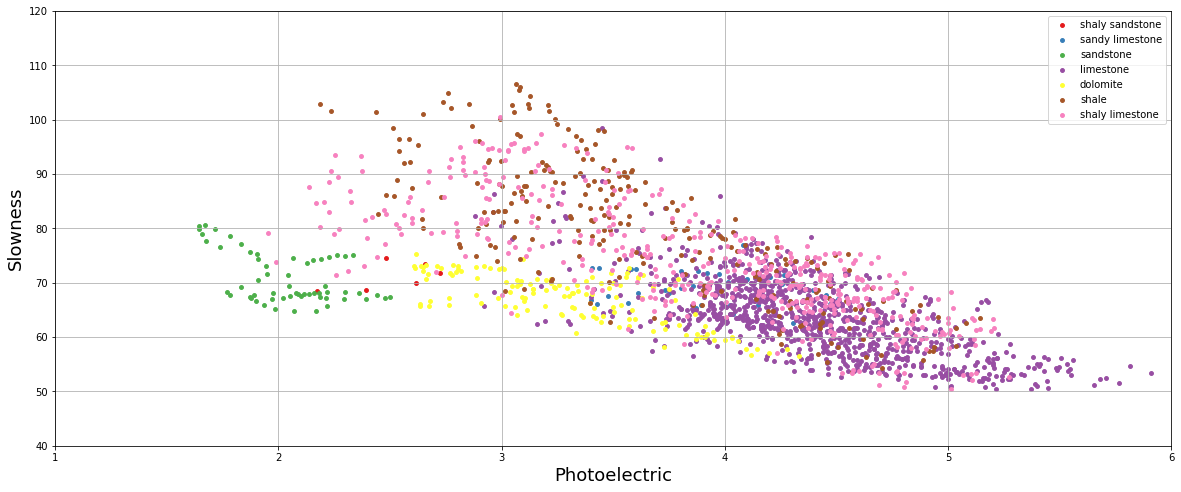

In [13]:
plot_scatter_type_of_formation(Log_Data['Photoelectric'],Log_Data['Delta-t (interval transit time, or slowness)'],Log_Data['Type of Formation'],axes=[1,6,40,120],x1label='Photoelectric',x2label='Slowness')

We can see that sandstone lithology is close to 2 Pe; dolomite lithology is between 2.6 and 4; and limestone lithology is higher than 3.6 approximately.
Shaly formations have a larger slowness.

### 3.4.2. Cross-Over/Separation & Neutron Porosity

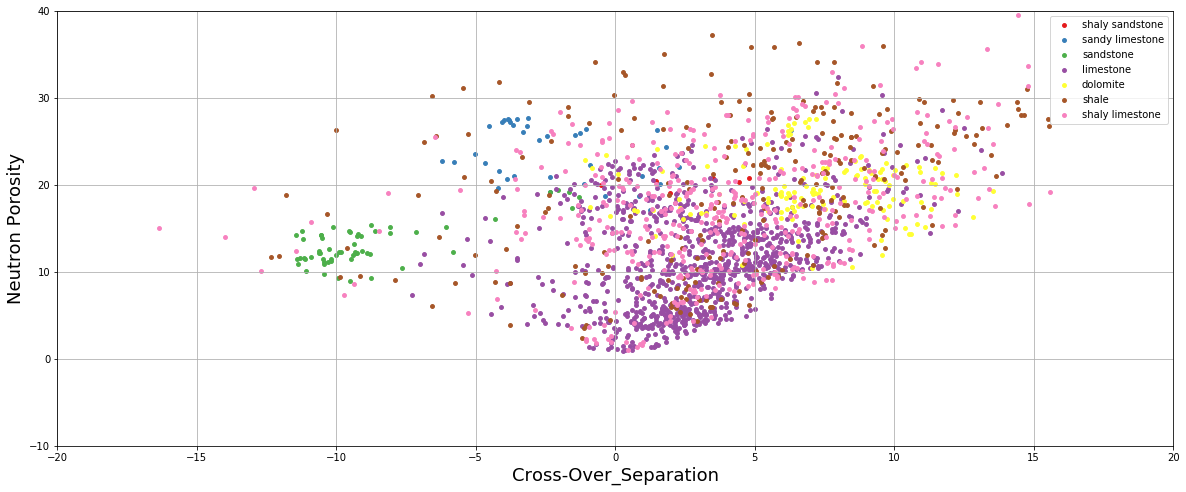

In [14]:
plot_scatter_type_of_formation(Log_Data['Cross-Over_Separation'],Log_Data['Neutron Porosity'],Log_Data['Type of Formation'],axes=[-20,20,-10,40],x1label='Cross-Over_Separation',x2label='Neutron Porosity')

The sandstone lithology shows a cross-over around 10 porosity units; the dolomite lithology is located in the right side of the graph, i.e., it presents separation. Limestone lithology was the matrix assumption, so it is expected that this labels are close to 0 cross-over/separation.

### 3.4.3. Deep Resistivity & Resistivity Invation

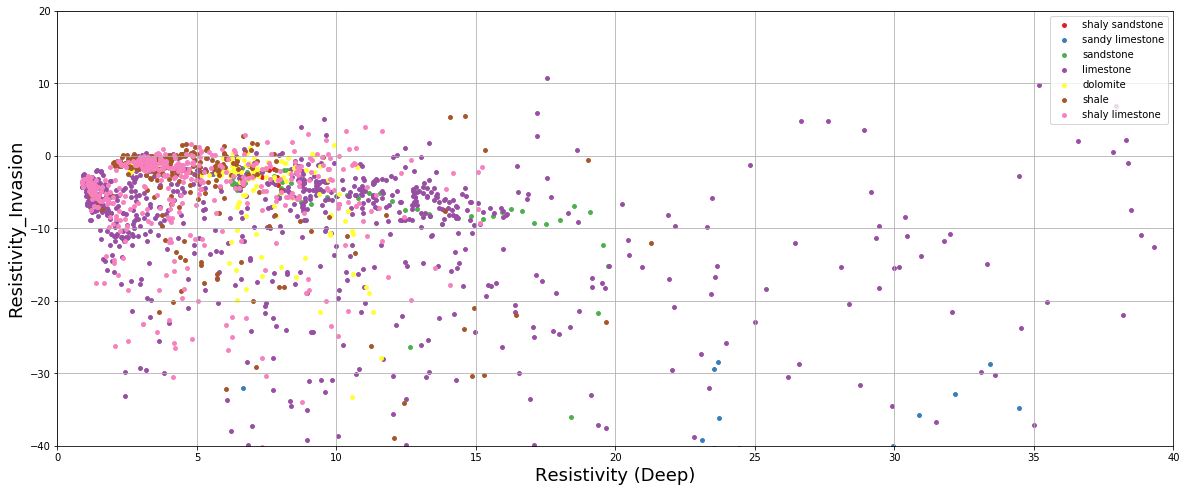

In [15]:
plot_scatter_type_of_formation(Log_Data['Resistivity (Deep)'],Log_Data['Resistivity_Invasion'],Log_Data['Type of Formation'],axes=[0,40,-40,20],x1label='Resistivity (Deep)',x2label='Resistivity_Invasion')

It is difficult to identify any patter from this scatter plot. Most of the instances have a negative Resistivity_Invation value. This means that the fluid type used for drilling purposes had a higher resistivity than the formation flow.
It is hard to identify a reservoir formation type. We would need more information for this task.

### 3.4.4. Depth & Gamma Ray
This section was added after trainining the final model and identify the most important features.

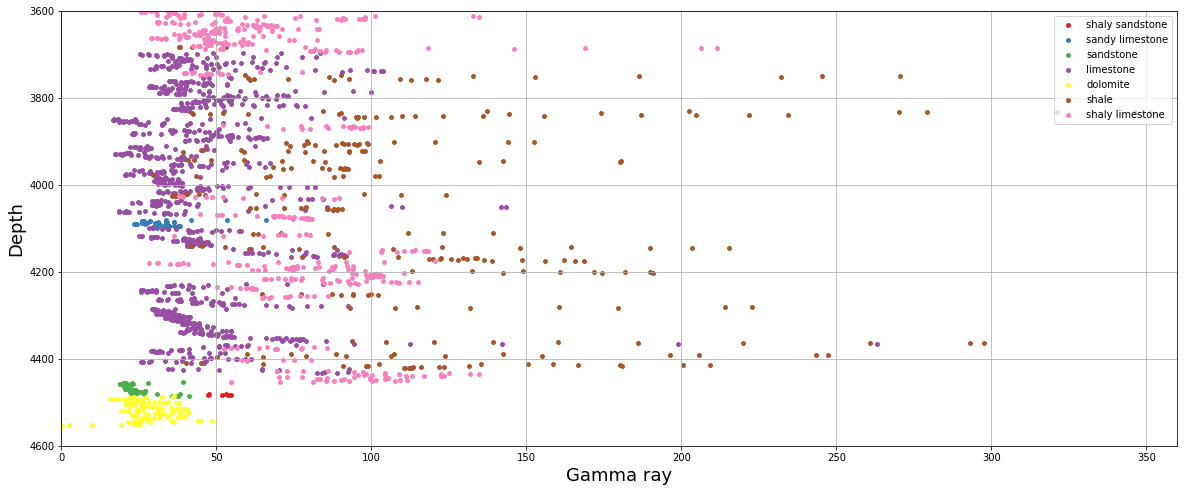

In [40]:
plot_scatter_type_of_formation(Log_Data['Gamma ray'],Log_Data['DEPTH'],Log_Data['Type of Formation'],axes=[0,360,4600,3600],x1label='Gamma ray',x2label='Depth')

## 3.5. Creating the Train and Test sets

The Log_Data array contains the attributes and the labels (lithologies). We need to separate this information into 2 different arrays.

Then, we will split the instances in a Training set and a Test Set. We will train different models and compare how well they generalize the Test set. In order to acomplish this, we will use the class 'train_test_split'. It splits arrays or matrices into random train and test subsets.

80% of the instances will belong to the training set.

In [16]:
Lithology_Labels=Log_Data['Type of Formation']
Log_Attributes=Log_Data.drop('Type of Formation',axis=1)

from sklearn.model_selection import train_test_split
Log_Attributes_train,Log_Attributes_test,Lithology_Labels_train,Lithology_Labels_test=train_test_split(Log_Attributes,Lithology_Labels,train_size=0.8,random_state=42)
Log_Attributes_train.head()

C:\Users\victo\AppData\Local\conda\conda\envs\datascience\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



,DEPTH,Neutron Porosity,Caliper,Gamma ray,Photoelectric,Bulk density,Density Correction,Resistivity (Deep),Ratio (shallow/deep resistivity),Spontaneous Potential,"Delta-t (interval transit time, or slowness)",Sonic porosity,Cross-Over_Separation,Resistivity_Invasion
141,3670.5,15.9255,7.8206,48.0693,4.3521,2.4276,-0.0066,1.8423,-72.0014,-16.0151,66.6065,13.4417,-0.5913,-9.7824
1010,4105.0,4.4988,7.9731,57.3899,4.3646,2.6878,-0.0208,40.4246,-19.1890,47.6622,55.1862,5.3650,3.2015,-25.6230
1103,4151.5,26.3788,8.5307,118.3198,2.8256,2.4289,0.1525,3.3747,-12.9824,70.2279,90.8188,30.5649,9.9406,-1.3295
1784,4492.0,16.3314,7.7790,18.1000,4.1440,2.6501,-0.0087,8.3836,-92.3737,29.6176,57.8142,7.2236,12.8295,-80.7015
339,3769.5,12.9397,8.0099,53.4096,4.3121,2.6005,-0.0069,2.6410,-36.8891,8.0120,66.2199,13.1683,6.5353,-4.1455


# 4. Machine Learning Model

## 4.1. Model Selection

The problem discuss previously is a Multiclass Classification task.

All attributes are numerical, and the target is categorical.

We are going to present different models and evaluate their performance to select the model with more potential.

### 4.1.1. Multinomial Logistic Regression

The Logistic Regression model can be generalized to support multiple classes directly, without having to train and combine binary classifiers. This is called Multinomial Logistic Regression.
This classifier predicts the class with highest estimated probability, minimizing the cost function called 'cross entropy'. Cross entropy is frequently used to measure how well a set of estimated class probabilities match the target classes.

In [17]:
from sklearn.linear_model import LogisticRegression
mult_lr_clf=LogisticRegression(multi_class='multinomial',solver='lbfgs',random_state=42) 
#Multinomial indicates the use of many classes
#Solver: Only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ support multiclass problems
mult_lr_clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

### 4.1.2. Support Vector Classifier

Support Vector Machine classifiers are strictly binary classifiers. However, we can set the hyperparameters of the class and it can support multiclass classification.
In order to take account nonlinearities in the features data, we can use the kernel trick to obtain similar results as if we had added similarity features, without adding computational complexity.
The Gaussian RBF kernel requires a scalling preprocessing of the feature values.

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
 
rbf_svm_clf=Pipeline([
    ('scaler',StandardScaler()),
    ('svm_clf',SVC(kernel='rbf',random_state=42,probability=True))
])
#probability=True: enable probability estimates.
rbf_svm_clf

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])

### 4.1.3. Random Forest Classifier

Random Forest is an ensemble of Decision Trees, generally trained via the bagging method. It introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of feature. This trades a higher bias for a lower variance, yielding an overall better model.

In [19]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf=RandomForestClassifier(random_state=42)
rnd_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### 4.1.4. Extra-Trees

Extremely Randomized Trees ensemble makes trees more random by also using random thresholds for each feature. This trades more bias for a lower variance. It also makes Extra-Trees much faster to train than regular Random Forest since finding the best possible threshold for each feature at every node is one of the most time-consuming task of growing a tree.

In [20]:
from sklearn.ensemble import ExtraTreesClassifier
extra_trees_clf=ExtraTreesClassifier(random_state=42)
extra_trees_clf

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

### 4.1.5. Voting Classifier

A simple way to create a better classifier is to aggregate the predictions of each classifier discussed previously, and predict the class that gets the most votes.
If all classifiers are able to estimate class probabilities we can use the hyperparameter voting='soft' to indicate that we want to predict the class with the highest probability, averaged over all the indivial classifiers.

In [21]:
from sklearn.ensemble import VotingClassifier
voting_clf=VotingClassifier(                                                   
        estimators=[('mlc',mult_lr_clf),('svc',rbf_svm_clf),('rf',rnd_clf),('et',extra_trees_clf)],    #List of (string,estimator) tuples
        voting='soft')                                                                                 #hard or soft
voting_clf

VotingClassifier(estimators=[('mlc', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('svc', Pip...estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

## 4.2. Traning the Model

The problem of Lithology Identification has been developed. The initial logging data has been clean and modified in order to have features that are related with the type of formation.
Also, we have splitted the instances. The training set is used in this stage to fit the model parameters of each model discussed previously.
The models disccused were selected because of their potential good performance. However, we will test them using the test set.
In the following code, we perform the training procedure for each model, we obtain a measurement of their perfomance (Accuracy Score) and the time required for each model to be fitted and to predict.

In [22]:
from sklearn.metrics import accuracy_score

for clf in (mult_lr_clf,rbf_svm_clf,rnd_clf,extra_trees_clf,voting_clf):
    start = time.time()
    clf.fit(Log_Attributes_train,Lithology_Labels_train)
    y_pred=clf.predict(Log_Attributes_train)
    print(clf.__class__.__name__,' Accuracy Score: ',accuracy_score(Lithology_Labels_train,y_pred)) #Accuracy is improved when the classifiers are grouped with voting
    end = time.time()
    print(clf.__class__.__name__,' Time: ',end - start)

LogisticRegression  Accuracy Score:  0.662303664921466
LogisticRegression  Time:  0.07579827308654785
Pipeline  Accuracy Score:  0.8848167539267016
Pipeline  Time:  0.2882699966430664
RandomForestClassifier  Accuracy Score:  0.9954188481675392
RandomForestClassifier  Time:  0.037858009338378906
ExtraTreesClassifier  Accuracy Score:  1.0
ExtraTreesClassifier  Time:  0.01998424530029297
VotingClassifier  Accuracy Score:  0.9856020942408377
VotingClassifier  Time:  0.3929128646850586


C:\Users\victo\AppData\Local\conda\conda\envs\datascience\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Note: 'Pipeline' correspond to the Support Vector Classifier model.

The accuracy score of ExtraTreesClassifier is 1. This indicates, probably, an overfitted model.

The VotingClassifier took more time (10 times longer) to execute the training and prediction, but his accuracy score is not higher than RandomForestClassier's score.

## 4.3. Model evaluation

The performance of the model is obtained using a dataset different than the one used for training purposes.
The metric used to measure the performance is Accuracy Score. In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in Lithology_Label_test.

In [23]:
for clf in (mult_lr_clf,rbf_svm_clf,rnd_clf,extra_trees_clf,voting_clf):                            #Final performance on the test set
    start = time.time()
    y_pred=clf.predict(Log_Attributes_test)
    print(clf.__class__.__name__,' Accuracy Score: ',accuracy_score(Lithology_Labels_test,y_pred))  #Accuracy is improved when the classifiers are grouped with voting
    end = time.time()
    print(clf.__class__.__name__,' Time: ',end - start)

LogisticRegression  Accuracy Score:  0.6727748691099477
LogisticRegression  Time:  0.0009970664978027344
Pipeline  Accuracy Score:  0.819371727748691
Pipeline  Time:  0.009973764419555664
RandomForestClassifier  Accuracy Score:  0.8743455497382199
RandomForestClassifier  Time:  0.0029909610748291016
ExtraTreesClassifier  Accuracy Score:  0.856020942408377
ExtraTreesClassifier  Time:  0.002993345260620117
VotingClassifier  Accuracy Score:  0.8664921465968587
VotingClassifier  Time:  0.013962745666503906


C:\Users\victo\AppData\Local\conda\conda\envs\datascience\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



According to the previous results, the RandomForestClassifier had a better scored than VotingClassifier, eventhough the training time was 10 times higher. For that reason, we selected RandomForestClassifier.

We would like to have a much better performance. The next step will be tuning the hyperparameters of this model.

## 4.4. Tuning the Model

### 4.4.1. Error Analysis
If we want to find a way to improve our model, we need to know the type of error that our model makes. Using the predictions of the currently model and comparing them with the real labels, we can obtain the confusion matrix.
To compare error rates instead of absolute number of error, we divided each value in the confusion matrix by the number of instances in the corresponding lithology type.

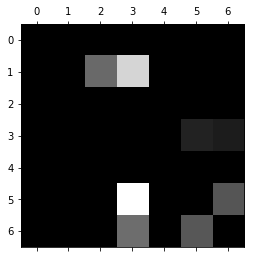

Order:  ['shaly sandstone', 'sandy limestone', 'sandstone', 'limestone', 'dolomite', 'shale', 'shaly limestone']


In [24]:
from sklearn.metrics import confusion_matrix
Labels=list(set(Log_Data['Type of Formation']))
Lithology_Labels_pred=rnd_clf.predict(Log_Attributes_test)
conf_mx=confusion_matrix(Lithology_Labels_test,Lithology_Labels_pred,labels=Labels)
row_sums=conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx=conf_mx/row_sums
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()
print('Order: ',Labels)

Now we can see the kinds of errors. Each row represents the actual lithologies, while columns represent predicted ones. The columns for 'limestone' is bright in the corresponding cells related with 'shaly limestone, shale, and sandy limestone'. This means that many instances were misclassified as limestone, instead of shaly limestone, shale, and sandy limestone.
Also, we can see that a few shaly limestone were misclassified as shale, and viceversa.

### 4.4.2. Grid Search
Now that we are aware of the current mistakes that our model committed during prediction task, we would like to know a great combination of hyperparameters values.
The GridSearchCV will search them for us. The parameters to consider are:
* n_estimator: The number of trees in the forest.
* criterion: 'gini' or 'entropy'. Function to measure the quality of the split. 
* max_features: The number of features to consider when looking for the best split.
* min_samples_split: The minimum number of samples required to split and internal node. 

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
start = time.time()
param_grid=[{'n_estimators':[10,50,100,200,300,400,500],
             'criterion':['gini','entropy'],
             'max_features':[6,8,10,13],
             'min_samples_split':[2,5,10],
             'random_state':[42]}]

grid_search=GridSearchCV(rnd_clf,param_grid,cv=5,scoring='accuracy')
grid_search.fit(Log_Attributes_train,Lithology_Labels_train)
end = time.time()
print(grid_search.best_params_)                                      #Parameters to the best fit
print(' Time searching for hyperparameters: ',end - start)
Lithology_Labels_pred=grid_search.best_estimator_.predict(Log_Attributes_test)
print(' Accuracy Score for Test Set: ',accuracy_score(Lithology_Labels_test,Lithology_Labels_pred))
print(' f1_score for Test Set: ',f1_score(Lithology_Labels_test,Lithology_Labels_pred,average='weighted'))

{'criterion': 'entropy', 'max_features': 8, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}
 Time searching for hyperparameters:  1505.0591189861298
 Accuracy Score for Test Set:  0.918848167539267
 f1_score for Test Set:  0.9185390962861675


The accuracy score of the model was 92% usign the test set.
The F1 score can be interpreted as a weigthed average of the precision and recall.

Now, let's consider the hyperparametes.
'min_samples_split' is 2. This is the lower limit and we cannot decrese it.
On the other hand, we could continue refining the other numerical hyperparameters.

In [33]:
start = time.time()
param_grid=[{'n_estimators':[80,90,100,110,120],
             'max_features':[8],
             'criterion':['entropy'],
             'random_state':[42]}]

grid_search=GridSearchCV(rnd_clf,param_grid,cv=5,scoring='accuracy')
grid_search.fit(Log_Attributes_train,Lithology_Labels_train)
end = time.time()
print(grid_search.best_params_)                                      #Parameters to the best fit
print(' Time searching for hyperparameters: ',end - start)
Lithology_Labels_pred=grid_search.best_estimator_.predict(Log_Attributes_test)
print(' Accuracy Score for Test Set: ',accuracy_score(Lithology_Labels_test,Lithology_Labels_pred))
print(' f1_score for Test Set: ',f1_score(Lithology_Labels_test,Lithology_Labels_pred,average='weighted'))

{'criterion': 'entropy', 'max_features': 8, 'n_estimators': 100, 'random_state': 42}
 Time searching for hyperparameters:  22.379217386245728
 Accuracy Score for Test Set:  0.918848167539267
 f1_score for Test Set:  0.9185390962861675


Now, we feel more confident about the hyperparameters selection.

### 4.4.3. Error Analysis Updated

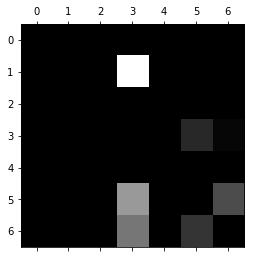

Order:  ['shaly sandstone', 'sandy limestone', 'sandstone', 'limestone', 'dolomite', 'shale', 'shaly limestone']


In [34]:
rnd_clf=RandomForestClassifier(criterion='entropy',n_estimators=100,max_features=8,random_state=42)
rnd_clf.fit(Log_Attributes_train,Lithology_Labels_train)

Lithology_Labels_pred=rnd_clf.predict(Log_Attributes_test)
conf_mx=confusion_matrix(Lithology_Labels_test,Lithology_Labels_pred,labels=Labels)
row_sums=conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx=conf_mx/row_sums
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()
print('Order: ',Labels)

According the previous figure, the number of error was reduced.

### 4.4.4. Feature Importance

Important features are likely to appear closer to the root of the tree, while unimportant features will often appear closer to the leaves. It is possible to get an estimate of a feature's importance by computing the average depth at which it appears across all trees in the forest.

In [39]:
for name,score in zip(list(Log_Attributes),rnd_clf.feature_importances_):
    print(name,score)

DEPTH 0.4211465248330578
Neutron Porosity 0.02771215256679095
Caliper 0.02632207995253686
Gamma ray 0.155109564973695
Photoelectric 0.07466066652888274
Bulk density 0.038798698902847116
Density Correction 0.045699665904360705
Resistivity (Deep) 0.03136054956043978
Ratio (shallow/deep resistivity) 0.01490817651884357
Spontaneous Potential 0.05825738232486856
Delta-t (interval transit time, or slowness) 0.030992701231564074
Sonic porosity 0.027362601005117733
Cross-Over_Separation 0.029742942810457192
Resistivity_Invasion 0.017926292886537794


The previous information shows that the most important features (or the features closer to the root of the forest) are the 'depth' and the 'gamma ray' log.

# 5. Results